<a href="https://colab.research.google.com/github/manikbali/DataAnalytics/blob/master/Process_GSICS_RAC_Products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GSICS Product User Platform[GSICS for ISCCP]
*By Manik Bali, ESSIC/UMD*

We present here a python platform built on Google Colab, aimed to help users use GSICS products. This has python codes that can help you 

1. Pick a GSICS product directly from  [GSICS Product Catalog](https://www.star.nesdis.noaa.gov/smcd/GCC/ProductCatalog.php)
2. Extract variables from GSICS products
3. Plot extracted Variables
4. Apply the correction coefficients to correct biases in monitored instrument and plot them
5. Instantly share your code and data with the GSICS community, its users and friends ( ISCCP, GEO, GCOS, WMO members )

**Features of GSICS User Google Colab Platform**:

Google Colab is a collaborative development environment. Its a Paradigm shift in the manner in which GSICS data and code are being shared. Here we are sharing data with a working instance of the algorithm and a python code. 
Members accessing this colab can contribute their modules to the Colab notebook as well as pick up code from here (under the GSICS GPL)

Currently accessible by most of the GSICS member agencies. It gives a python run time environment directly in your browser. The platform is shareable, comes free and has cloud computing resources inbuilt into it.
GSICS members can make contributions of code directly into the colab library.

**How to plot variables in a GSICS products**

The first part of the code reads in GSICS data( NetCDF) that resides on the GSICS product Catalog and plots the bias on the Stadard Scene.
One can plot any variable extracted from the GSICS Product. Here we plot the Standard Scente Temp bias time series.

**How to use Correction Coefficients to correct biases**

The second part of the code uses the GSICS Correction coefficients that can be used to correct the operationally produced radiance in the GEO
Meteosat/SEVIRI L1.5 data, LGEO, so its calibration is consistent with that of the LEO reference instrument, Metop/IASI, LLEO.

The steps uses are the following

The operational radiance, LGEO, is calculated from the L1.5 counts as:

Equation 1:


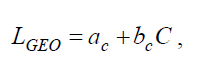


where C is the pixel count, ac and bc are the operational offset and slope calibration 
coefficients, respectively, referred to as Cal_Offset and Cal_Slope in the L1.5 files [AD-3].

The GSICS Corrected radiance is then given by Equation 2, which may be re-written as


Equation 2 [ Corrected Radiance can be written as]:

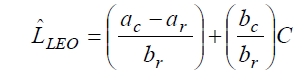

where ar  and br  are the coefficients of the GSICS Correction given in the netCDF file as the 
variables offset and slope, respectively.

This is equivalent to  changing the space count  and calibration coefficient in Equation 4 to
ag=(ac- ar)/br and bg= (bc/br), respectively.


Modus Operandi
The code reads in the correction coefficients and applies these on a synthetic GEO measurement to get an estimate of the impact of using GSICS Correction Coefficients


**References**

EUMETSAT GSICS Product User Guide [link](https://www.eumetsat.int/website/wcm/idc/idcplg?IdcService=GET_FILE&dDocName=PDF_DMT_803180&RevisionSelectionMethod=LatestReleased&Rendition=Web)

In [ ]:
!pip install netCDF4
!pip install julian
!pip install cftime

import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import urllib.request
from datetime import date
import julian
import matplotlib
from cftime import num2pydate
from netCDF4 import num2date
import pandas as pd
from datetime import datetime
import urllib.request


     |████████████████████████████████| 4.7MB 7.5MB/s 
     |████████████████████████████████| 317kB 40.8MB/s 
  Created wheel for julian: filename=julian-0.14-cp36-none-any.whl size=2636 sha256=b65bf2f1a80774d7167e62e6068ae74066dae4ba6f2beb77d599a89f3764ce59
  Stored in directory: /root/.cache/pip/wheels/ce/b7/8a/aa742c5ae0a627cc1a665f14550988c012f8c38fc15c2f80b9
Successfully built julian


In [ ]:
#nc_file = "W_XX-EUMETSAT-Darmstadt,SATCAL+RAC+GEOLEOIR,MSG1+SEVIRI-MetOpA+IASI_C_EUMG_20150601000000_01.nc"
#url = "http://gsics.eumetsat.int/thredds/fileServer/msg1-seviri-metopa-iasi-oper-rac/"
nc_file="W_XX-EUMETSAT-Darmstadt,SATCAL+RAC+GEOLEOIR,MSG2+SEVIRI-PRIME_C_EUMG_20080601000000_demo_00.nc"
url="http://gsics.eumetsat.int/thredds/fileServer/msg2-seviri-prime-demo-rac/"
urllib.request.urlretrieve(url+nc_file, nc_file)

('W_XX-EUMETSAT-Darmstadt,SATCAL+RAC+GEOLEOIR,MSG2+SEVIRI-PRIME_C_EUMG_20080601000000_demo_00.nc',
 <http.client.HTTPMessage at 0x7fe5a8bf41d0>)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

# Open the GSICS netCDF file and read variables [ You can add in more]
with nc4.Dataset(nc_file,'r') as ncid:
     std_bias      = ncid.variables['std_scene_tb_bias'][:][:] # Standard Scene TB Bias
     time_array    = ncid.variables['date'][:] #time
     freq_array    = ncid.variables['wnc'][:] #wnc
     std_scene_tb    = ncid.variables['std_scene_tb'][:] # Scene TB
     delta_slope    = ncid.variables['delta_slope'][:] # Slope
     delta_offset    = ncid.variables['delta_offset'][:] # Offset
     reference_name    = ncid.variables['reference_name'][:] # Refname
     alpha             = ncid.variables['alpha'][:] # Alpha
     beta              = ncid.variables['beta'][:] # Beta
     br0              = ncid.variables['slope'][:] # Slope
     ar0              = ncid.variables['offset'][:] # Offset
     time_array =time_array/86400.0

14031 18490
[datetime.datetime(2008, 6, 1, 0, 0) datetime.datetime(2008, 6, 2, 0, 0)
 datetime.datetime(2008, 6, 3, 0, 0) ...
 datetime.datetime(2020, 8, 13, 0, 0) datetime.datetime(2020, 8, 14, 0, 0)
 datetime.datetime(2020, 8, 15, 0, 0)] (4459, 8)
[0.389 0.625 0.735 0.871 0.966 1.073 1.196 1.33 ]
4459


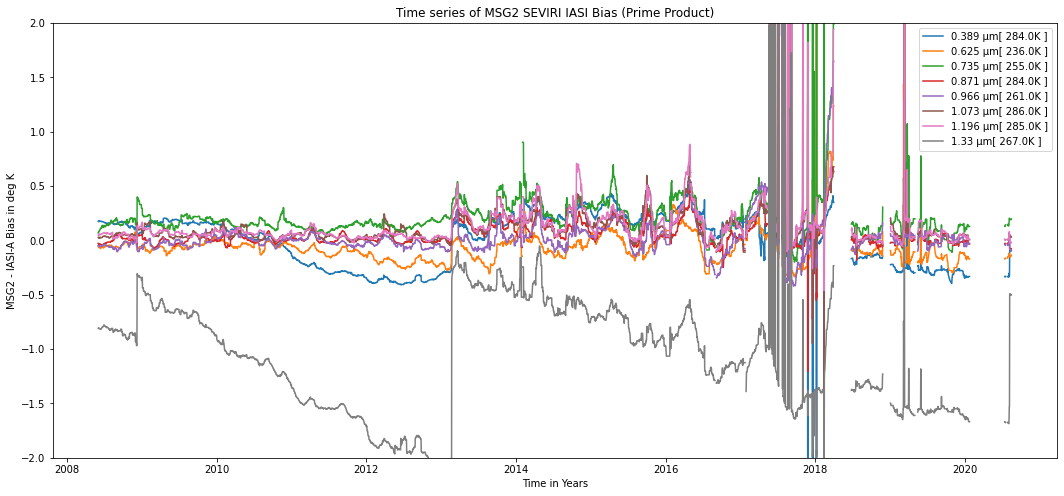

In [ ]:
#Construct a data frame with observation days in the first column
#However this has missing days and at time repeated days.
dtime_days=pd.DataFrame(time_array.astype(int),columns=list('t'))
std_df = pd.DataFrame(std_bias)
std_df.columns.name = 'standard_scene_bias'

#print(ar.shape,br.shape,time_array.shape)

ar_df=pd.DataFrame(ar0)
ar_df.columns.name = 'offset'

br_df=pd.DataFrame(br0)
br_df.columns.name = 'bias'



std_df.columns=freq_array
df_time_std_bias=[dtime_days,std_df]
df_time_ar=[dtime_days,ar_df]
df_time_br=[dtime_days,br_df]

#df_time_std_bias=[dtime_days,std_df,ar_df,br_df]
df_time_bias=pd.concat(df_time_std_bias,axis=1) # Data Frame with time information added in column
df_time_ar=pd.concat(df_time_ar,axis=1) # Data Frame with time information added in column
df_time_br=pd.concat(df_time_br,axis=1) # Data Frame with time information added in column

#Construct a data time series such that days are evenly placed
#However this has missing days. Fill Nan on these days. Also drop duplicate days if any

print(time_array[0].astype(int),time_array[-1].astype(int))
new_index = pd.Index(np.arange(time_array[0].astype(int),time_array[-1].astype(int)), name="t")
temp=df_time_bias.drop_duplicates(subset=['t'])
ar_temp=df_time_ar.drop_duplicates(subset=['t'])
br_temp=df_time_br.drop_duplicates(subset=['t'])


df_reindex=temp.set_index("t").reindex(new_index)
df_array=df_reindex.to_numpy()

df_reindex_ar=ar_temp.set_index("t").reindex(new_index)
df_array_ar=df_reindex_ar.to_numpy()

df_reindex_br=br_temp.set_index("t").reindex(new_index)
df_array_br=df_reindex_br.to_numpy()

ar=df_array_ar.copy()
br=df_array_br.copy()
cr=df_array_ar/df_array_br

cf=1000/np.array(freq_array)
cf=np.around(cf,decimals=3)
cfreq = [[str(freq)] + [u"\u03bcm"] for freq in cf  ]
cfreq = [ ' '.join(freq) for freq in cfreq ]


cfreq=[ ''.join(cfreq[fr] +"[ " + str(std_scene_tb[fr])+ "K ]") for fr in range(len(cfreq))]


#Pull out the column with time information and convert it to date time format
plt.figure(figsize=(18,8))
plt.ylim(-2, 2)
days_since1970=num2pydate(df_reindex.index,'days since 1970-01-01')
plt.plot(days_since1970,df_array)

print(days_since1970, df_reindex.shape)
plt.title('Time series of MSG2 SEVIRI IASI Bias (Prime Product)')
plt.xlabel('Time in Years')
plt.ylabel('MSG2 - IASI-A Bias in deg K')
plt.legend(cfreq) 
print(cf)
#print(''.join(str(reference_name)) )
print(len(days_since1970))



In [ ]:
print(df_reindex.head())

       2568.832031  1600.547974  ...  836.445007   751.791992 
t                                ...                          
14031     0.175598    -0.057755  ...     0.049255    -0.808167
14032     0.174805    -0.060959  ...     0.048798    -0.807251
14033     0.172516    -0.058792  ...     0.047302    -0.807861
14034     0.175354    -0.063187  ...     0.053070    -0.805450
14035     0.173309    -0.065826  ...     0.050568    -0.810791

[5 rows x 8 columns]


8 4459
35672 8


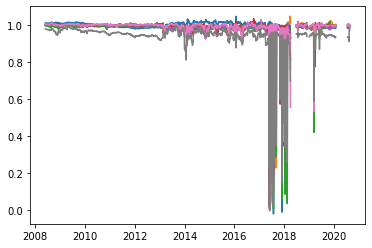

In [ ]:
import math
c1 = 1.19104e-05
c2 = 1.43877
alpha=np.array(alpha)
beta=np.array(beta)
nchans=np.size(alpha)
wnc=np.array(freq_array.copy())
N=(c1 * wnc*wnc*wnc)
std_scene_rad=(c1 * wnc*wnc*wnc) / ((np.exp(c2 * wnc/(alpha * std_scene_tb + beta))) - 1.)
print (nchans,len(days_since1970) )

rad_bias_array=np.zeros((nchans,len(days_since1970)),dtype='f')
ref_bt=np.zeros((nchans,len(days_since1970)),dtype='f')
ref_rad=np.zeros((nchans,len(days_since1970)),dtype='f')
gsics_corr_rad=np.zeros((nchans,len(days_since1970)),dtype='f')
radiance=np.zeros((nchans),dtype='f')
gsics_corr_bt=np.zeros((nchans,len(days_since1970)),dtype='f')
bt_bias_array=np.zeros((nchans,len(days_since1970)),dtype='f')
print(ref_bt.size, nchans)
plt.plot(days_since1970,df_array_br)

In [ ]:
for n in range(len(days_since1970)-2):
#  print(n,nchans, len(days_since1970),len(std_scene_tb), df_array.shape,ref_bt.shape )
  ref_bt[:,n]= std_scene_tb - df_array[ n,: ]
  tempp=ref_bt[:,n].copy()
  ref_rad[:,n]= (c1 * wnc*wnc*wnc) / ((np.exp(c2 * wnc/(alpha * tempp + beta))) - 1.)

  gsics_corr_rad[:,n]= std_scene_rad/br[n,:]-cr[n,: ]
  radiance[:]=  gsics_corr_rad[:,n].copy()

  gsics_corr_bt[:,n]=   ((c2 * wnc)/np.log(1.+(c1 * wnc*wnc*wnc)/radiance)-beta)/alpha

  bt_bias_array[:,n]=gsics_corr_bt[:,n] -  ref_bt[:,n]
#  bt_bias_array[:,n]=gsics_corr_bt[:,n] -  std_scene_tb[:]





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


(8, 4459)
[datetime.datetime(2008, 6, 1, 0, 0) datetime.datetime(2008, 6, 2, 0, 0)
 datetime.datetime(2008, 6, 3, 0, 0) ...
 datetime.datetime(2020, 8, 13, 0, 0) datetime.datetime(2020, 8, 14, 0, 0)
 datetime.datetime(2020, 8, 15, 0, 0)] (4459, 8)


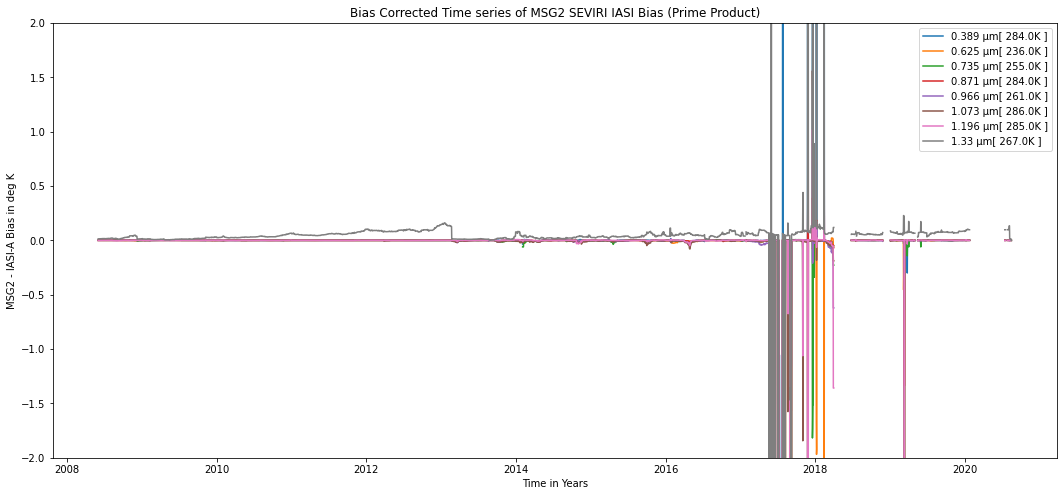

In [ ]:
print(bt_bias_array.shape)
plt.figure(figsize=(18,8))
plt.ylim(-2, 2)
plt.plot(days_since1970, np.transpose(bt_bias_array))

print(days_since1970, df_reindex.shape)
plt.title('Bias Corrected Time series of MSG2 SEVIRI IASI Bias (Prime Product)')
plt.xlabel('Time in Years')
plt.ylabel('MSG2 - IASI-A Bias in deg K')
plt.legend(cfreq) 

In [ ]:
 range(len(days_since1970))

range(0, 4459)

In [ ]:
pip install mirpyidl

     |████████████████████████████████| 184kB 8.8MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
